# Preprocessing

In [1]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data=pd.read_csv('adult.csv', encoding='latin')
print('Shape:', data.shape)

# Printing sample data
# Start observing the Quantitative/Categorical/Qualitative variables
data.head(5)

Shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0


In [2]:
Target=data.columns[-1]
Feature_names=np.array(data.columns)[:-1]
print(Target)
print(Feature_names)

income
['age' 'workclass' 'fnlwgt' 'education' 'educational-num' 'marital-status'
 'occupation' 'relationship' 'race' 'gender' 'capital-gain' 'capital-loss'
 'hours-per-week' 'native-country']


In [3]:
y = data[Target]
X = data.drop(axis=1,labels=Target,inplace=False)

In [4]:
aa=X.nunique()

Continousfeatures=[]
Categoricalfeatures=[]

for i in range(len(Feature_names)):
    if aa[i]>30:
        Continousfeatures.append(Feature_names[i])
    else:
        Categoricalfeatures.append(Feature_names[i])

print(Continousfeatures)
print(Categoricalfeatures)

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
['workclass', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender']


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,test_size=0.2,random_state=428)



X_train=train.drop(axis=1,labels=Target,inplace=False)
y_train=train[Target]

X_test=test.drop(axis=1,labels=Target,inplace=False)
y_test=test[Target]

In [6]:
for i in Categoricalfeatures:
    X[i].astype("category")
    X_train[i].astype("category")
    X_test[i].astype("category")


# Implemente XGBOOST

In [7]:
import xgboost as xgb

In [9]:
clf = xgb.XGBClassifier(
    n_estimators=50,
    enable_categorical=True,  #  si True, tree_method = "gpu_hist" or "hist" or "approx"
    tree_method="approx",      # "gpu_hist" or "hist" or "approx" or "exact"
    #max_depth,booster,random_state,tree_method
)

clf.fit(X_train, y_train)

prediction=clf.predict(X_test)

import matplotlib.pyplot as plt

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))


              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7442
           1       0.78      0.67      0.72      2327

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769

[[6995  447]
 [ 779 1548]]
Accuracy of the model on Testing Sample Data: 0.87


# implemente SHAP

In [10]:
import shap

In [11]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
np.shape(shap_values)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(48842, 14)

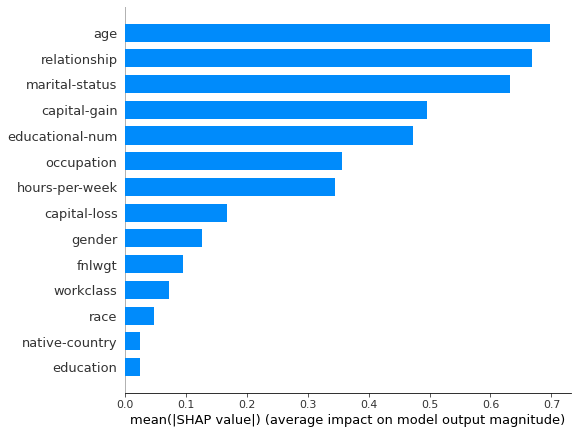

In [12]:
shap.summary_plot(shap_values,X,plot_type="bar")

# try to use different method of combination/reduction of dimension

# PCA

In [57]:
Prediction=clf.predict(X)

explained_variance_ratio: [0.4106159 0.2534751]


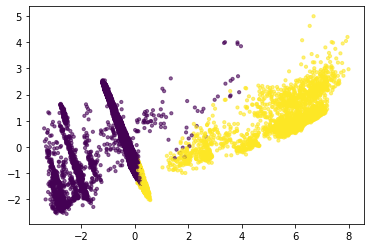

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=500)

data2=pca.fit_transform(shap_values)
print("explained_variance_ratio:",pca.explained_variance_ratio_)
plt.scatter(data2[:,0],data2[:,1], c=Prediction,alpha = 0.6, s=10)



# MDS

In [17]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,
                metric = True, #default True
                dissimilarity='euclidean' # default euclidean
               )

stress: 186901.1811631757


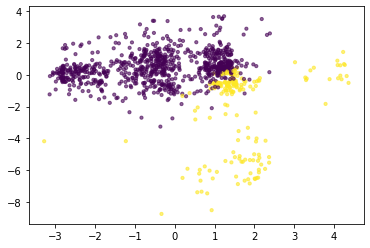

In [18]:
X_mds= embedding.fit_transform(shap_values[:1000])
print("stress:",embedding.stress_)
plt.scatter(X_mds[:,0],X_mds[:,1],c=Prediction[:1000], alpha = 0.6, s=10)

# UMAP

In [19]:
import umap
reducer = umap.UMAP(n_components=2)

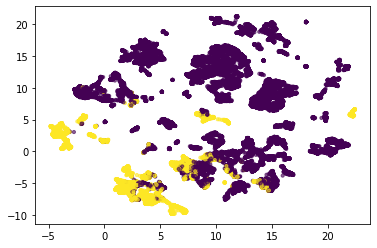

In [21]:
embedding = reducer.fit_transform(shap_values)
plt.scatter(embedding[:,0],embedding[:,1],c=Prediction, alpha = 0.6, s=10)

## (t-SNE is too slow, give up)
# ==============================================
# we choose the result of UMAP
# Clustering

## dbscan (need to choose proper value of epsilon and M)

In [97]:
from sklearn.cluster import DBSCAN

epsilon = 1
M = 100

result_dbscan = DBSCAN(eps = epsilon, min_samples = M+1,algorithm='brute').fit_predict(embedding)

In [91]:

a=[]
for i in range(len(set(result_dbscan))):
    a.append([[],[]])

for i in range(len(data)):
        a[result_dbscan[i]][0].append(embedding[i][0])
        a[result_dbscan[i]][1].append(embedding[i][1])      

In [100]:
import matplotlib
import matplotlib.cm as cm

N=len(np.unique(result_dbscan))
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.9,N)]


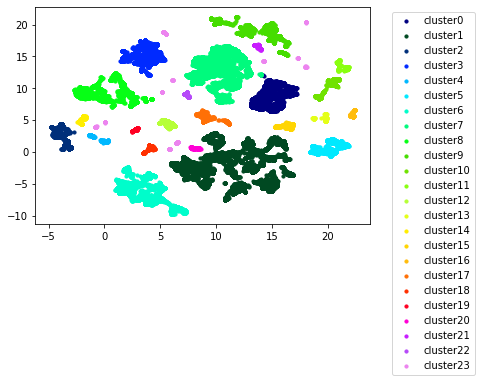

In [101]:
fig=plt.figure()
ax = fig.add_subplot(111)
for i in range(N):
    ax.scatter(a[i][0],a[i][1],s=10,color=colors[i],label='cluster'+str(i))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


## we choose cluster0 (the segment centered at (15,10) ) to use Skope-rules

In [115]:
clusterN=0

label_for_skope=np.zeros(len(Prediction))
avp=0
for i in range(len(Prediction)):
    if result_dbscan[i]==clusterN:
        label_for_skope[i]=1
        avp+=Prediction[i]

print("number of points:", int(label_for_skope.sum()))
print("average prediction:",avp/label_for_skope.sum())       

number of points: 4239
average prediction: 0.0


In [117]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

skp = SkopeRules(
                 max_depth=5,
                 max_depth_duplication=2,
                 n_estimators=50,
                 precision_min=0.3,
                 recall_min=0.05,
                 feature_names=Feature_names
                 )
 
skp.fit(X, label_for_skope)
print("Rules")
print()
for rule in skp.rules_:
    print("rule:" ,rule[0])
    print("precision:",rule[1][0])
    print("recall:", rule[1][1])
    print()
print(20*'=')
print()

Rules

rule: age > 24.5 and hours-per-week <= 41.5 and occupation <= 9.5 and occupation > 4.5 and relationship > 0.5
precision: 0.8057528847415165
recall: 0.8354877491575192




## kmeans

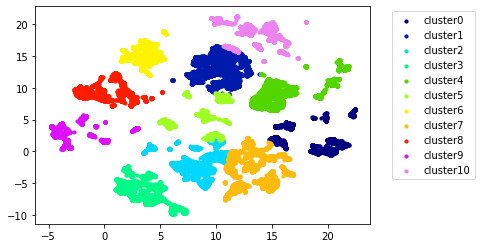

In [122]:
from sklearn.cluster import KMeans

N_clusters=11 # please choose 

kmeans = KMeans(n_clusters=N_clusters, random_state=7)

result_kmeans=kmeans.fit_predict(embedding)

a=[]
for i in range(N_clusters):
    a.append([[],[]])

for i in range(len(Prediction)):
        a[result_kmeans[i]][0].append(embedding[i][0])
        a[result_kmeans[i]][1].append(embedding[i][1])
        

N=N_clusters
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.9,N)]

fig=plt.figure()
ax = fig.add_subplot(111)
for i in range(N_clusters):
    ax.scatter(a[i][0],a[i][1],color=colors[i],s=10,label='cluster'+str(i))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## we choose cluster3(the green segment at the bottom) to use Skope-rules 

In [123]:
clusterN=3

label_for_skope=np.zeros(len(Prediction))
avp=0
for i in range(len(Prediction)):
    if result_kmeans[i]==clusterN:
        label_for_skope[i]=1
        avp+=Prediction[i]

print("number of points:", int(label_for_skope.sum()))
print("average prediction:",avp/label_for_skope.sum())  

number of points: 4488
average prediction: 0.8696524064171123


In [126]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

skp = SkopeRules(
                 max_depth=3,     ###  change this to reach high precision 
                 max_depth_duplication=2,
                 n_estimators=50,    ###  change this to reach high precision
                 precision_min=0.3,
                 recall_min=0.05,
                 feature_names=Feature_names
                 )
 
skp.fit(X, label_for_skope)
print("Rules")
print()
for rule in skp.rules_:
    print("rule:" ,rule[0])
    print("precision:",rule[1][0])
    print("recall:", rule[1][1])
    print()
print(20*'=')
print()

Rules

rule: capital-gain <= 727.5 and educational-num > 12.5 and relationship <= 0.5
precision: 0.8203375146381714
recall: 0.8860305846875659

rule: educational-num > 12.5 and relationship > 4.5
precision: 0.723792472067807
recall: 0.11415086620345799


